In [106]:
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [107]:
import taurex.log
taurex.log.disableLogging()

In [108]:
from taurex.cache import OpacityCache,CIACache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("../../atmosphere/xsecs")
CIACache().set_cia_path("../../atmosphere/cia/hitran")


In [109]:
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1200.0)

In [110]:
from taurex.planet import Planet
planet = Planet(planet_radius=1.7420,planet_mass=1.170)  #in jupiter masses

#parameters retrieved from https://ui.adsabs.harvard.edu/abs/2024AJ....168..231S/abstract

In [111]:
from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6628,radius=1.461)

In [112]:
from taurex.chemistry import TaurexChemistry
from taurex.chemistry import ConstantGas
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)
# H2O, CH4, CO2 and CO randomised within [10^{-8},10^{-2}].
rng = np.random.default_rng(seed=100)
chemistry.addGas(ConstantGas('H20',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CH4',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CO2',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CO',mix_ratio=rng.uniform(1e-8,1e-2)))

In [113]:
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution

tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()
res = tm.model()
res

(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333], shape=(76744,)),
 array([0.0160977 , 0.01613024, 0.0159089 , ..., 0.01583692, 0.01583695,
        0.01583698], shape=(76744,)),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.08710276e-010, 1.08710276e-010, 1.08710276e-010],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.10576658e-264, 9.28936531e-265, 7.80343340e-265],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         8.01701937e-167, 7.18002676e-167, 6.43020330e-167],
        ...,
        [9.33559432e-001, 8.12833966e-001, 9.94108024e-001, ...,
         9.96181405e-001, 9.96180296e-001, 9.96179186e-001],
        [9.71893807e-001, 8.59807327e-001, 9.96763477e-001, ...,
         9.97876359e-001, 9.97875741e-001, 9.97875123e-001],
        [9.89408347e-001, 9.28885909e-001, 9.98575574e-001, ...,
         9.99081512e-001, 9.99081245e-001, 9.9

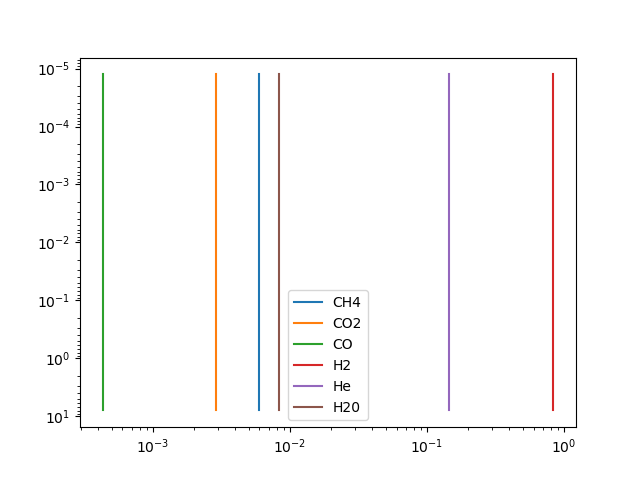

In [114]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

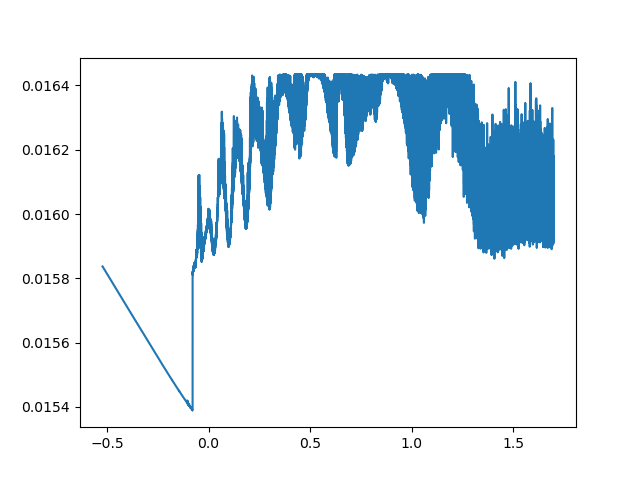

In [122]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

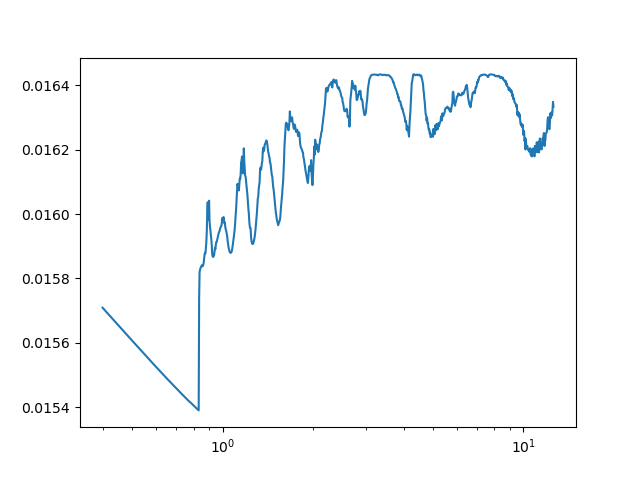

In [116]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()

In [172]:
from astropy.table import Table
t = Table.read("./partd/COCONUTS_2_b_3.12783_5519_1.tbl", format="ipac")
t["CENTRALWAVELNG", "FLAM", "FLAMERR1", "FLAMERR2"].write(
    "cocospectrum.dat",
    format="ascii.no_header")

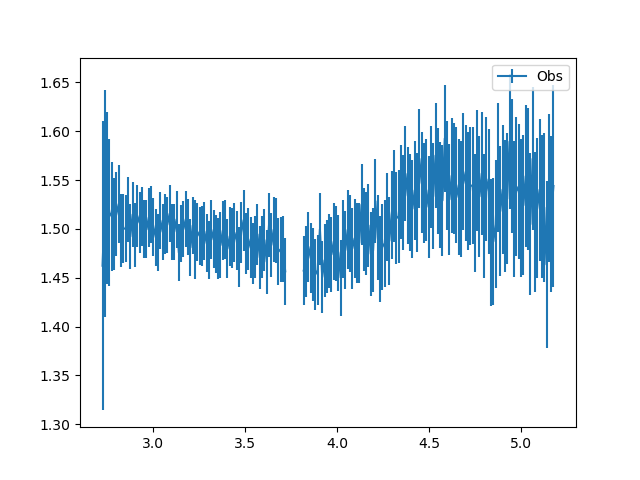

Text(0.5, 1.0, 'WASP-121b Spectrum')

In [119]:
from taurex.data.spectrum.observed import ObservedSpectrum
from taurex.binning import SimpleBinner

obs = ObservedSpectrum('./WASP121bspectrum.dat')
#Make a logarithmic grid or a linear in the wavelength
wngrid = np.sort(10000/np.linspace(2.7,5.2,200))
bn = SimpleBinner(wngrid=wngrid)

bin_obs= bn.bindown(obs.wavenumberGrid, obs.spectrum)
errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)
obin = obs.create_binner()

plt.figure()
plt.errorbar(1e4/wngrid, bin_obs[1], yerr=errorbars[1], label='Obs')
#plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.legend()
plt.show()
plt.xlabel("wavelength (microns)")
plt.ylabel("Transit Depth")
plt.title("WASP-121b Spectrum")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

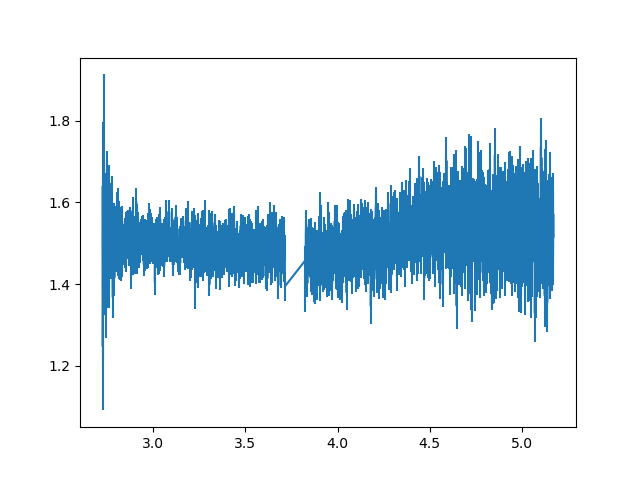

In [ ]:
chemistry2 = TaurexChemistry(fill_gases=['H2','He'],ratio=0.15)
# paper says they used H2, He collision but not the ratio....
rng = np.random.default_rng(seed=100)
chemistry2.addGas(ConstantGas('H2O',1e-5))
chemistry2.addGas(ConstantGas('SiO',1e-4))
chemistry2.addGas(ConstantGas('CO2',1e-5))
chemistry2.addGas(ConstantGas('CO',10e-2))
tm2 = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry2,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e10,
                       nlayers=30)
tm2.add_contribution(AbsorptionContribution())
tm2.add_contribution(CIAContribution(cia_pairs=['H2-He']))
tm2.add_contribution(RayleighContribution())
tm2.build()
res2 = tm2.model()
obin = obs.create_binner()

plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm2.model(wngrid=obs.wavenumberGrid)),[1]label='TM')
plt.legend()
plt.show()


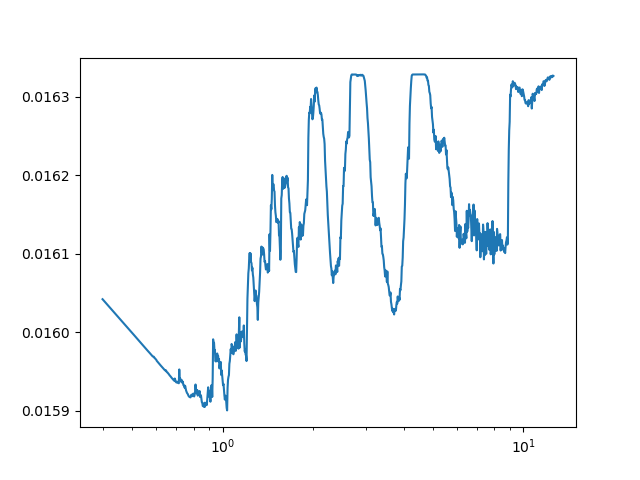

In [ ]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm2.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()
# THIS IS WHAT MODEL LOOKS LIKE BEFORE FITTING... WHY NOT WORKING WHEN PLOTTING AGAINST OBS??????

In [101]:
list(tm2.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T_irr',
 'kappa_irr',
 'kappa_v1',
 'kappa_v2',
 'alpha',
 'T_int_guillot',
 'H2O',
 'SiO',
 'CO2',
 'He_H2']

In [175]:
from taurex.optimizer.nestle import NestleOptimizer

opt = NestleOptimizer(num_live_points=500)
opt.set_model(tm2)
opt.set_observed(obs)
opt.enable_fit('planet_radius')
opt.enable_fit("T_irr")
opt.enable_fit("H2O")
#opt.enable_fit("SiO")
#opt.enable_fit("CO2")
#opt.enable_fit("He_H2")
opt.set_boundary("H2O",[1e-5,1e-3])
opt.set_boundary('T_irr',[1500,2500])
opt.set_boundary('planet_radius',[0.7,1.5])

In [186]:
for gas in chemistry2.activeGases:
    print(
        gas
    )

H2O
CO2


In [176]:
solution = opt.fit()
taurex.log.disableLogging()

it=   466 logz=-1271686.303897niter: 467
ncall: 967
nsamples: 967
logz: -1271685.803 +/-  0.001
h:  0.001


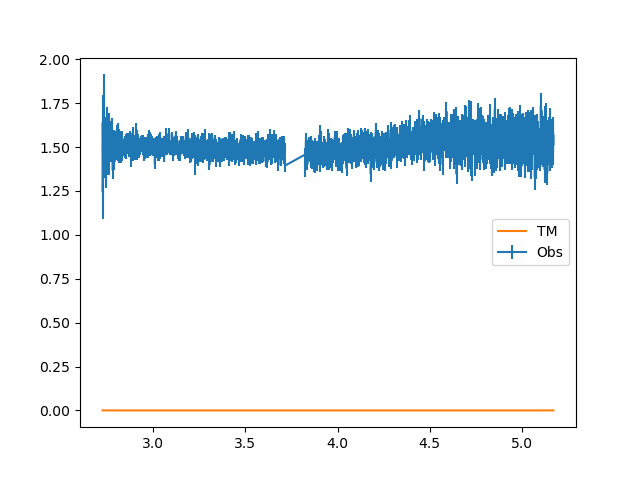

In [177]:
for solution, optimized_map, optimized_value, values in opt.get_solution():
    opt.update_model(optimized_map)

    # tm2.model returns just the spectrum
    spec = tm2.model(obs.wavenumberGrid)

    # Bin it
    binned = obin.bin_model(spec)[1]

    # Plot
    plt.figure()
    plt.errorbar(obs.wavelengthGrid, obs.spectrum, obs.errorBar, label="Obs")
    plt.plot(obs.wavelengthGrid, binned, label="TM")
    plt.legend()
    plt.show()


In [170]:
## lewis gave up on making the modelling work... cant even tell if the modelling is wrong or the binning is wrong?
## there is not enough documentation about the python part here to know what the issue is or what i should expect
## from the model output or what everything is returning exactly....